In [1]:
# 범례 한글 적용
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams['font.family'] = 'AppleGothic'   # Mac

/var/folders/qk/10b0q2j971j6d2py2x39ys200000gn/T/ipykernel_9854/4089818610.py:3: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  gd    = pd.read_csv("games_details.csv")


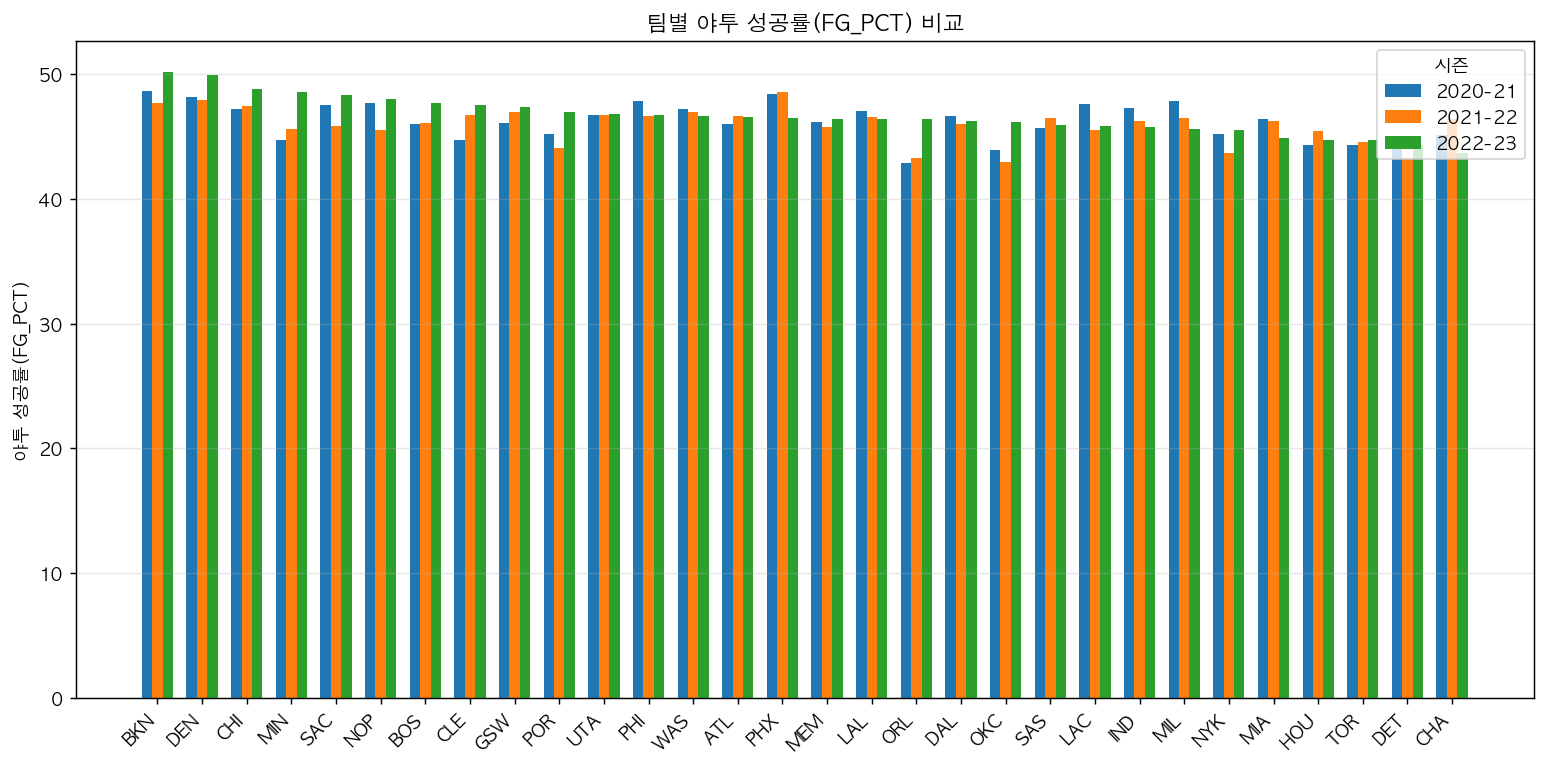

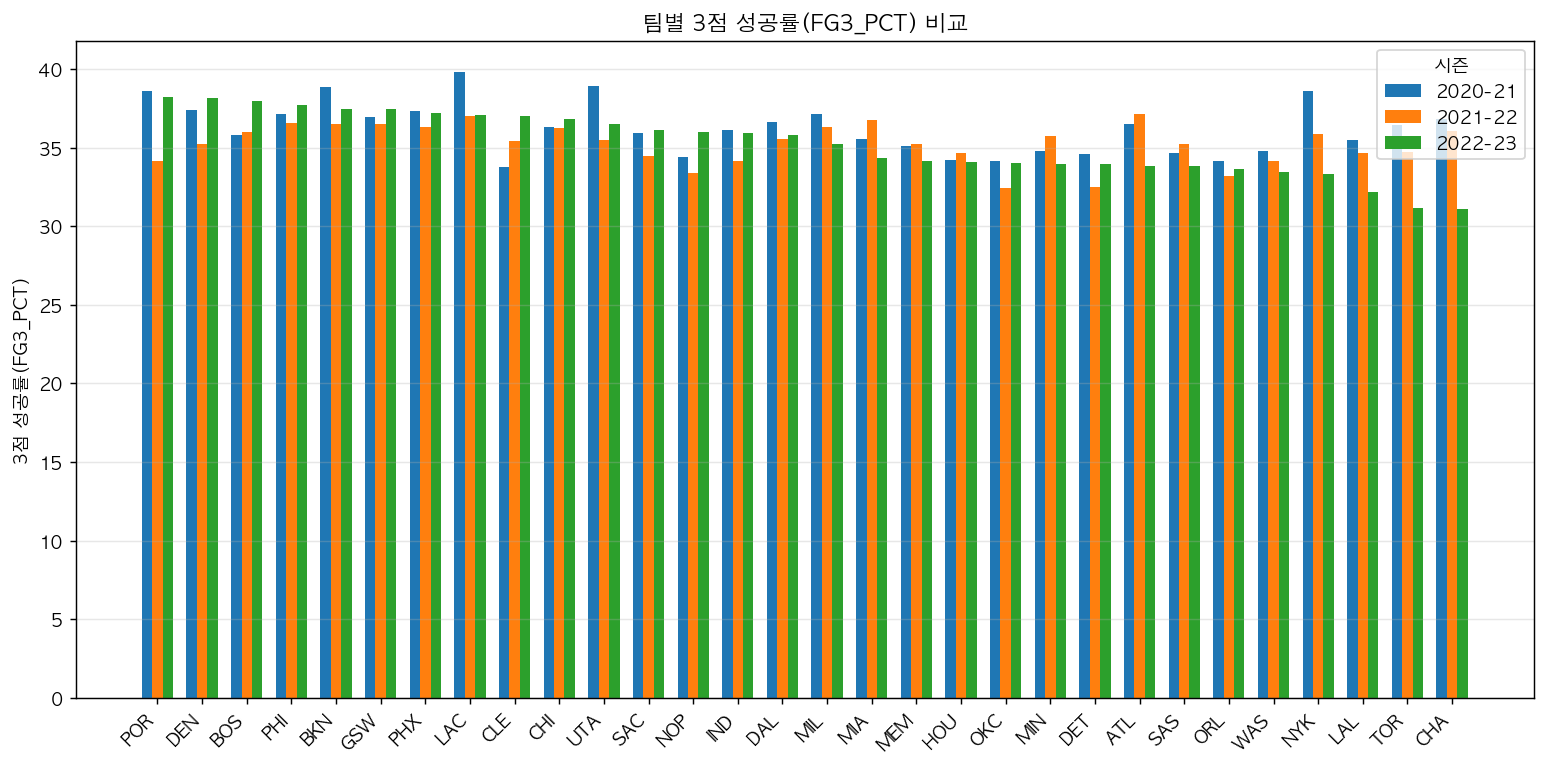

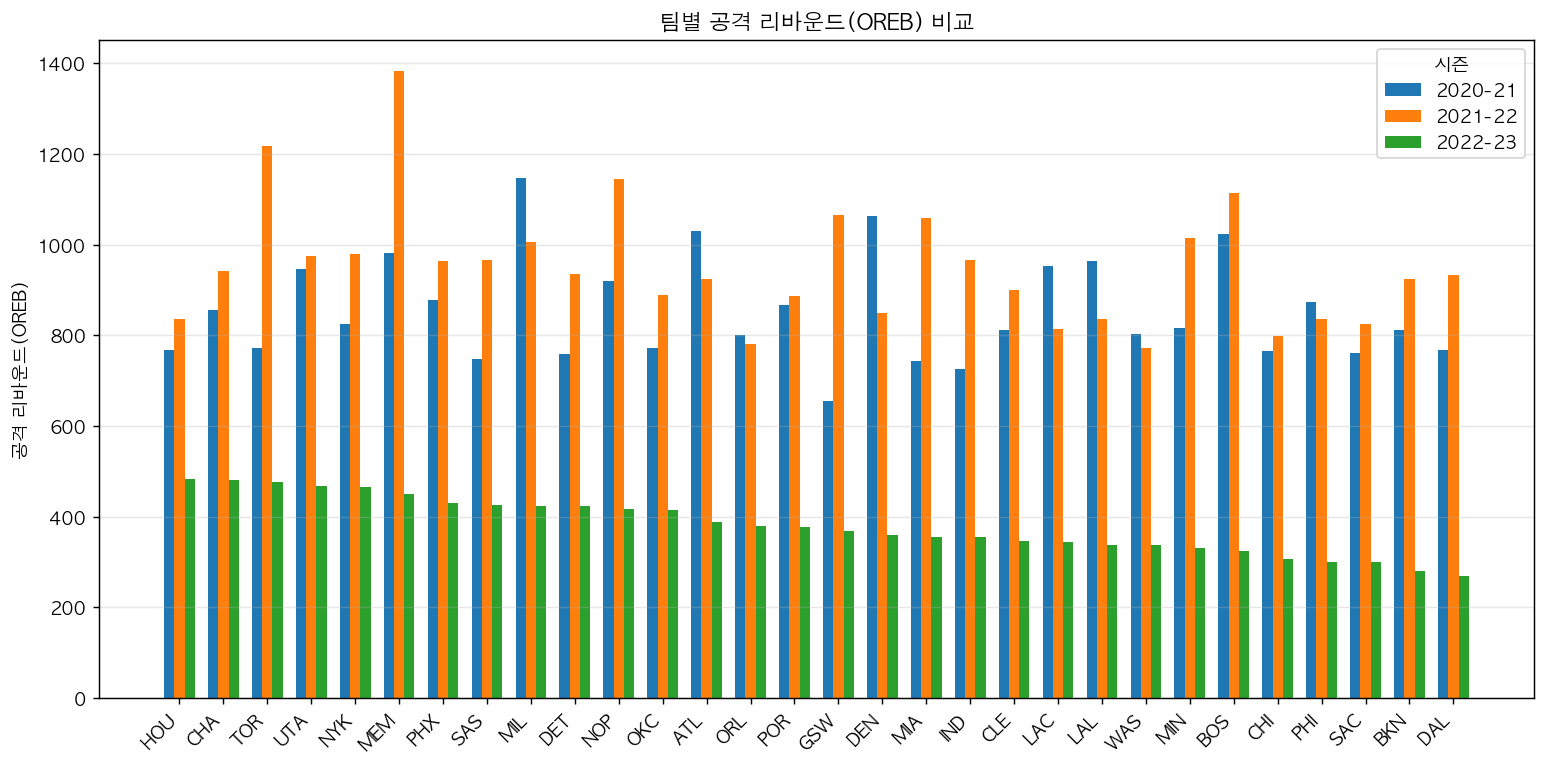

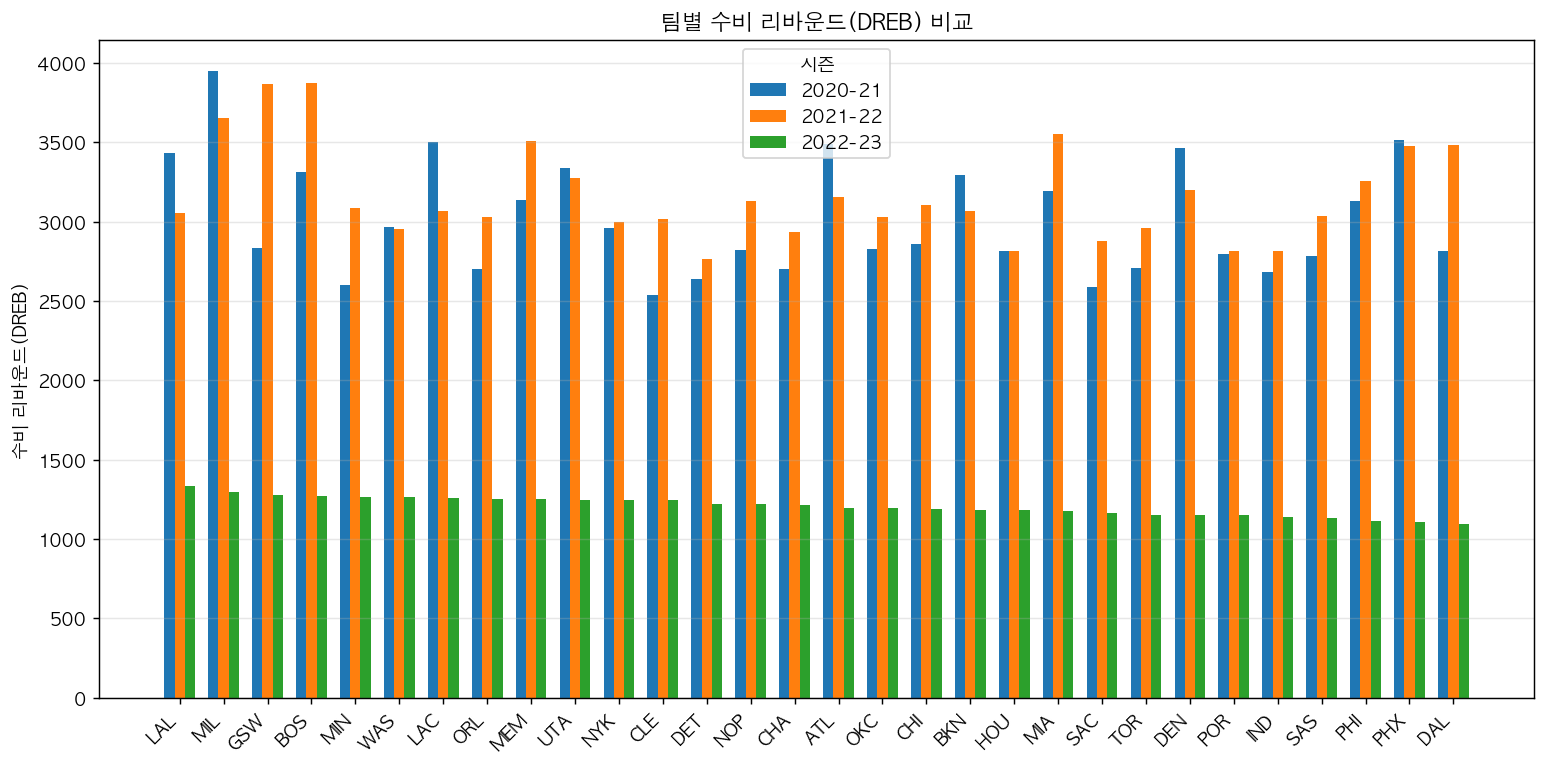

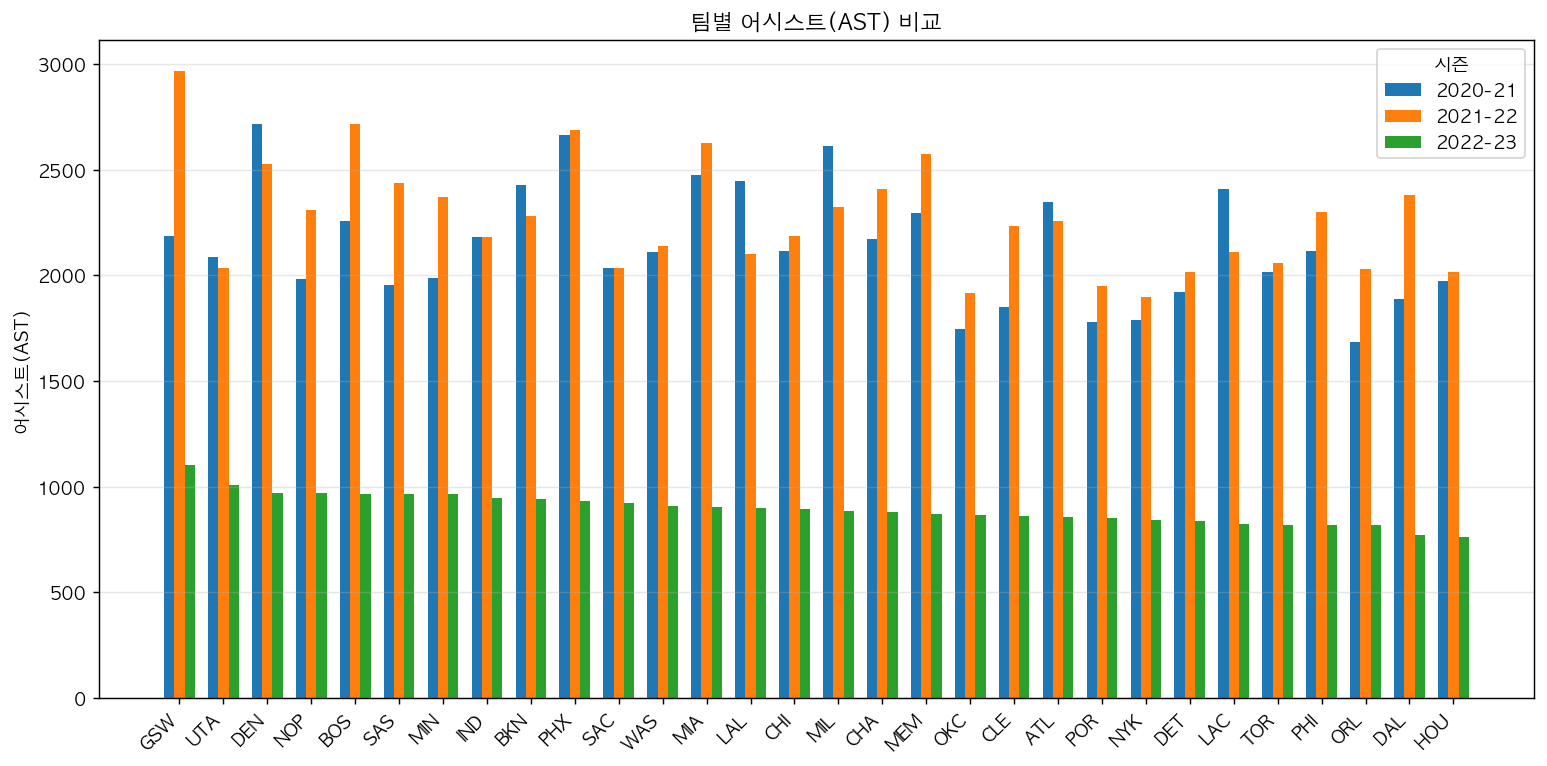

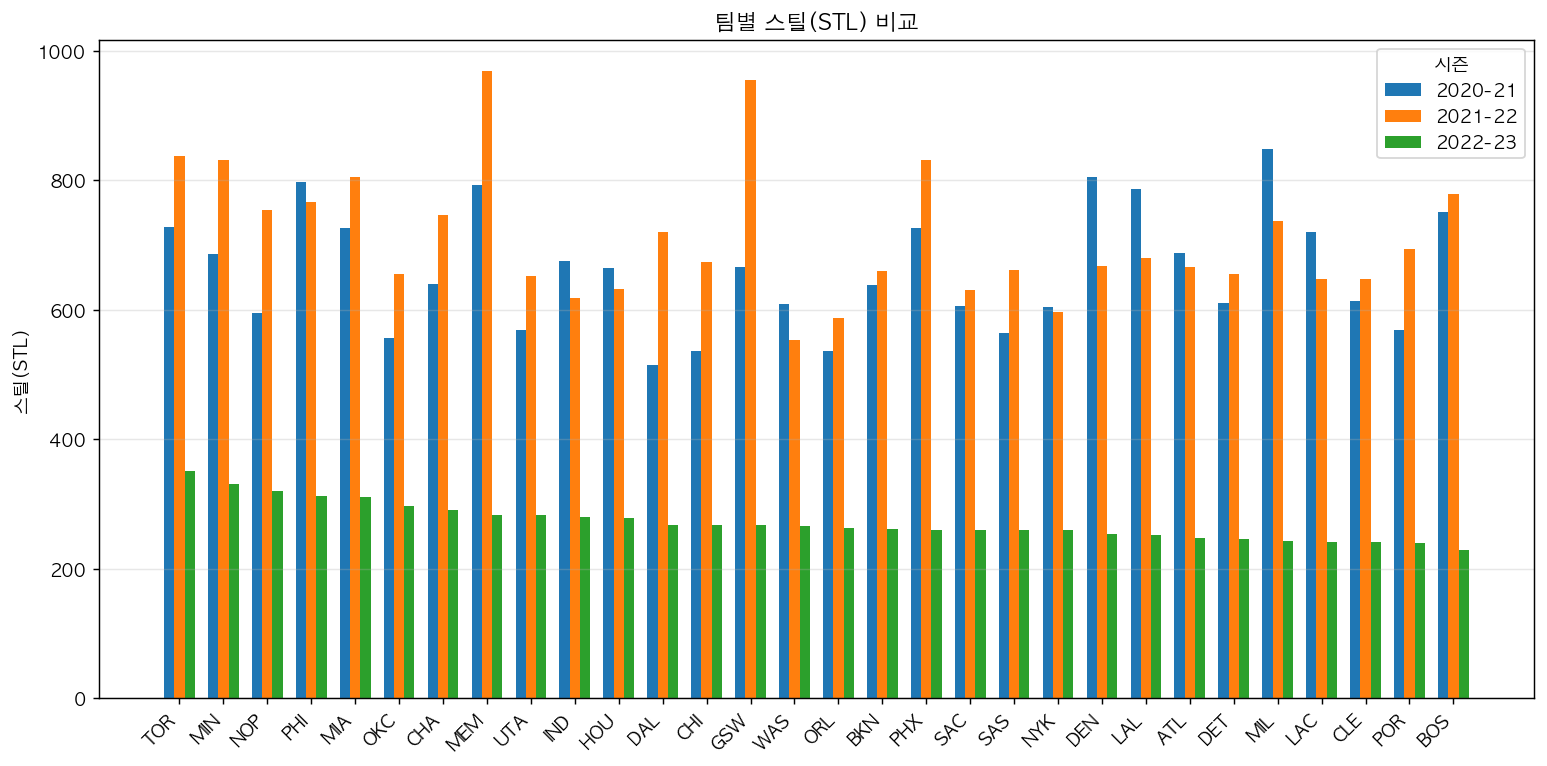

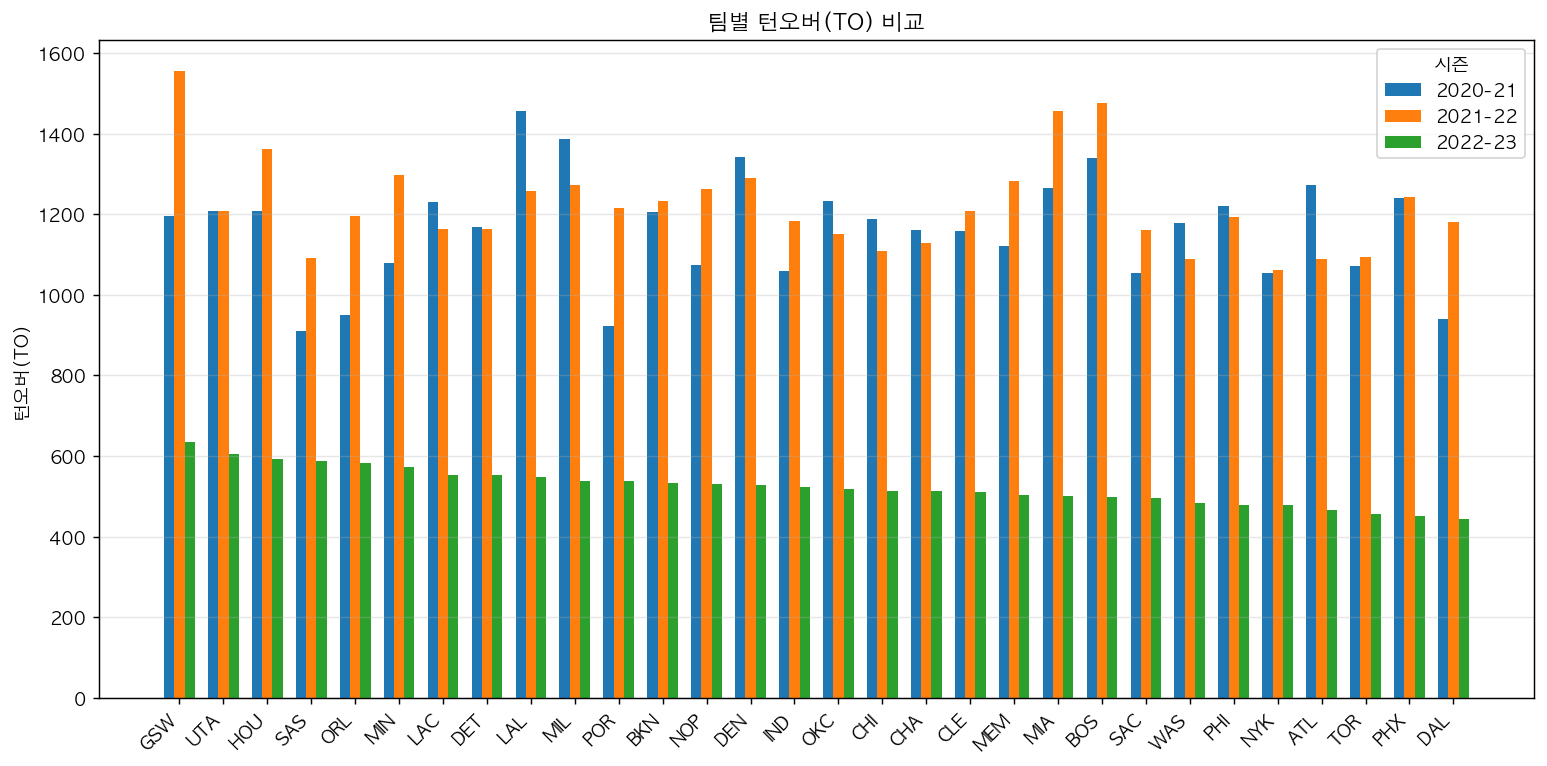

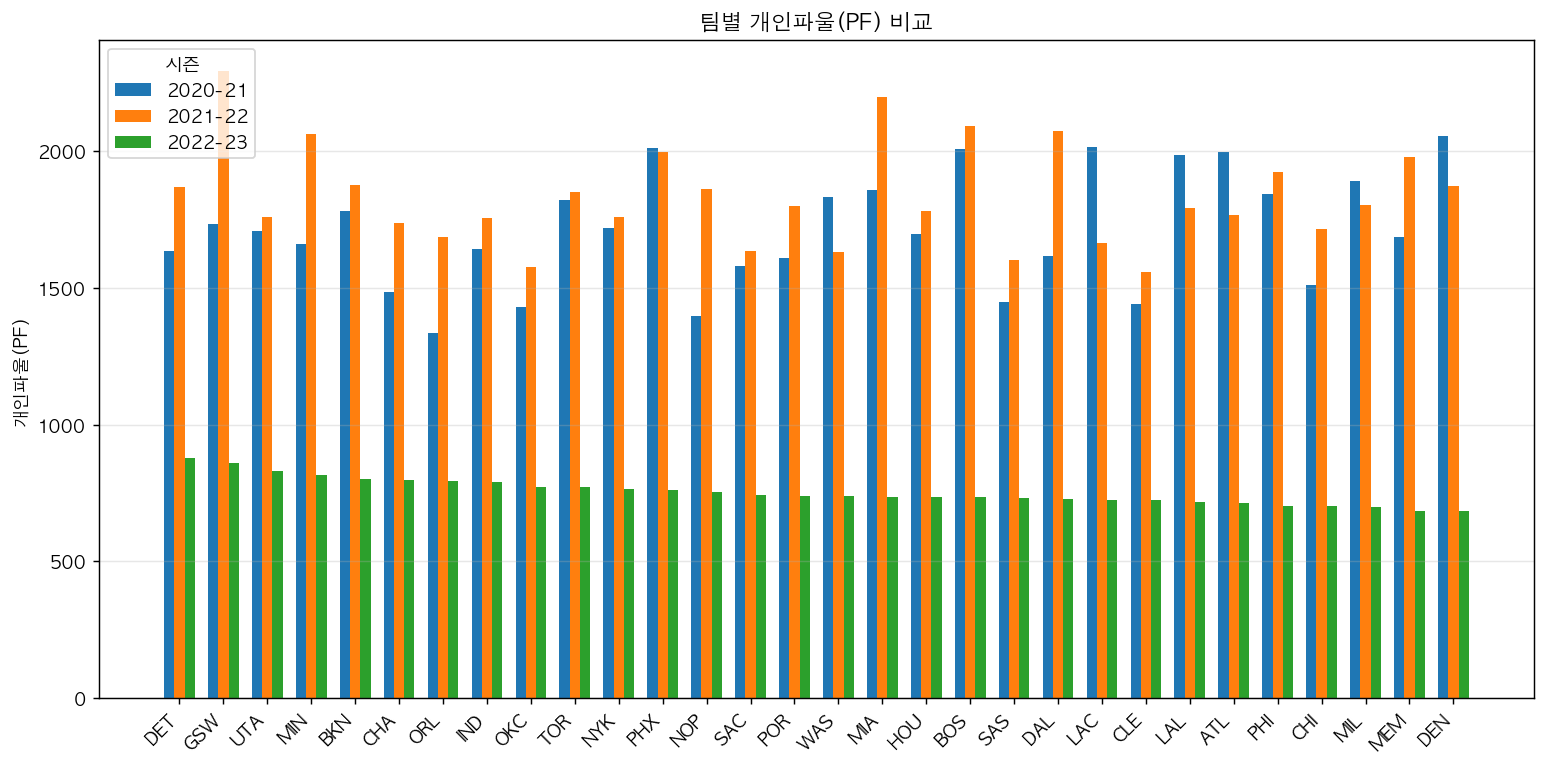

In [13]:
# 1) 로드
games = pd.read_csv("games.csv")
gd    = pd.read_csv("games_details.csv")

# 2) 시즌 시작연도(SEASON_START)
if "SEASON_ID" in games.columns:
    # SEASON_ID가 있으면 뒤 4자리만 사용 (예: 22022 -> 2022)
    games["SEASON_START"] = games["SEASON_ID"].astype(str).str[-4:].astype(int)
else:
    # 날짜 컬럼 후보 중에서 하나 선택
    date_candidates = ["GAME_DATE_EST", "DATE"]
    date_col = next((c for c in date_candidates if c in games.columns), None)
    if date_col is None:
        raise KeyError(f"날짜 컬럼이 없습니다. 후보: {date_candidates}")
    games[date_col] = pd.to_datetime(games[date_col], errors="coerce")
    games["SEASON_START"] = np.where(
        games[date_col].dt.month >= 9,
        games[date_col].dt.year,
        games[date_col].dt.year - 1
    )

# 3) 조인(게임 상세 + 시즌)
merged = gd.merge(games[["GAME_ID", "SEASON_START"]], on="GAME_ID", how="left")

# 4) 팀 컬럼
team_col = "TEAM_ABBREVIATION" if "TEAM_ABBREVIATION" in merged.columns else "TEAM_NAME"

# 5) 시즌×팀 요약
rows = []
for (season, team), g in merged.groupby(["SEASON_START", team_col]):
    season_label = f"{season}-{str(season+1)[-2:]}"
    row = {"시즌": season_label, team_col: team}

    # 성공률
    fgm, fga = g["FGM"].sum(), g["FGA"].sum()
    fg3m, fg3a = g["FG3M"].sum(), g["FG3A"].sum()
    row["야투 성공률(FG_PCT)"]  = (fgm/fga*100) if fga else np.nan
    row["3점 성공률(FG3_PCT)"] = (fg3m/fg3a*100) if fg3a else np.nan

    # 합계 지표
    if "OREB" in g.columns: row["공격 리바운드(OREB)"] = g["OREB"].sum()
    if "DREB" in g.columns: row["수비 리바운드(DREB)"] = g["DREB"].sum()
    if "AST"  in g.columns: row["어시스트(AST)"]       = g["AST"].sum()
    if "STL"  in g.columns: row["스틸(STL)"]          = g["STL"].sum()
    if "TO"   in g.columns: row["턴오버(TO)"]         = g["TO"].sum()
    if "PF"   in g.columns: row["개인파울(PF)"]       = g["PF"].sum()

    rows.append(row)

out = pd.DataFrame(rows)

# 6) 그래프 함수
def plot_metric(metric, seasons=("2020-21","2021-22","2022-23"), top_n=30):
    df = out[out["시즌"].isin(seasons)].copy()
    if df.empty or metric not in df.columns:
        print(f"[주의] '{metric}' 데이터가 없습니다."); return

    latest = seasons[-1]
    top_teams = (df[df["시즌"]==latest]
                 .sort_values(metric, ascending=False)[team_col]
                 .head(top_n).tolist())
    df = df[df[team_col].isin(top_teams)]

    x = np.arange(len(top_teams))
    width = 0.7/len(seasons)
    fig, ax = plt.subplots(figsize=(12,6))
    for i, s in enumerate(seasons):
        vals = (df[df["시즌"]==s]
                .set_index(team_col)
                .reindex(top_teams)[metric].values)
        ax.bar(x + (i-(len(seasons)-1)/2)*width, vals, width=width, label=s)

    ax.set_xticks(x)
    ax.set_xticklabels(top_teams, rotation=45, ha="right")
    ax.set_ylabel(metric)
    ax.set_title(f"팀별 {metric} 비교")
    ax.legend(title="시즌"); ax.grid(axis="y", alpha=0.3)
    plt.tight_layout(); plt.show()

# 7) 실행
plot_metric("야투 성공률(FG_PCT)")
plot_metric("3점 성공률(FG3_PCT)")
plot_metric("공격 리바운드(OREB)")
plot_metric("수비 리바운드(DREB)")
plot_metric("어시스트(AST)")
plot_metric("스틸(STL)")
plot_metric("턴오버(TO)") 
plot_metric("개인파울(PF)")
